## Previsão da inflação acumulada do ano de 2024 no Brasil

## O modelo final ajustado retornou o valor de 4.1%. É um modelo otimista!
## A inflação com certeza ficará entre 3.8% e 4.7%

## De acordo com o resultado obtido, o país consegue se manter dentro da meta de inflação. A meta permite ficar entre 3% e 4.5% -- ninguém acredita que o país vá atingir a meta fechada estipulada em 3%.

## Porém, perceba que, caso haja exagero na força dos estímulos monetários, pode-se ver o índice ir além dessa margem aceitável.

## Nota: as expectativas de inflação já influenciam a inflação efetiva. Caso o Banco Central exagere nos estímulos monetários, ou seja, abaixe demais os juros básicos, o primeiro item que se move é a expectativa de inflação. A partir desse primeiro movimento, os outros começam a se reajustar e o índice pode subir para além da margem aceitável.




---



## Vamos ao trabalho:

## Carrego algumas bibliotecas que sempre utilizarei:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

In [3]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


In [2]:
import gspread

## Vou carregar a planilha com os dados da inflação

#### Fonte de dados: IBGE, Diretoria de Pesquisas, Coordenação de Índices de Preços, Sistema Nacional de Índices de Preços ao Consumidor.
Disponível em: https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=downloads

In [4]:
url = "https://docs.google.com/spreadsheets/d/1lKoL4yJhY6IkqCL2qkzKQ5dE8py-GTN9/export?format=csv"
dados = pd.read_csv(url)

In [5]:
#colocar a coluna Date como datetime
dados['Date'] = pd.to_datetime(dados['Date'])
#vou apagar o localizado na linha 0
dados.drop(dados.index[0], inplace=True)

In [6]:
dados.head()

,Date,acumul.,variaç.
1,1994-03-01,3417.39,42.75
2,1994-04-01,3828.49,42.68
3,1994-05-01,4331.19,44.03
4,1994-06-01,4922.60,47.43
5,1994-07-01,4005.08,6.84


## Filtrar os dados para 2000 em diante

In [7]:
# Filtrar os dados a partir de janeiro de 2000
df = dados[dados['Date'] >= '2000-01-01']
df.head()

,Date,acumul.,variaç.
71,2000-01-01,8.85,0.62
72,2000-02-01,7.86,0.13
73,2000-03-01,6.92,0.22
74,2000-04-01,6.77,0.42
75,2000-05-01,6.47,0.01


In [8]:
#vou renomear o dataframe para Date, inflacao, variacao
df.rename(columns={'Date': 'date', 'acumul.': 'inflacao', 'variaç.': 'variacao'}, inplace=True)

<ipython-input-8-01af6af97284>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Date': 'date', 'acumul.': 'inflacao', 'variaç.': 'variacao'}, inplace=True)


## Organizei os dados e ele ficaram assim:

In [9]:
df.head()

,date,inflacao,variacao
71,2000-01-01,8.85,0.62
72,2000-02-01,7.86,0.13
73,2000-03-01,6.92,0.22
74,2000-04-01,6.77,0.42
75,2000-05-01,6.47,0.01


## Vou rodar um gráfico pairplot para verificar alguma relação muito evidente entre as varáveis

<Figure size 800x500 with 0 Axes>

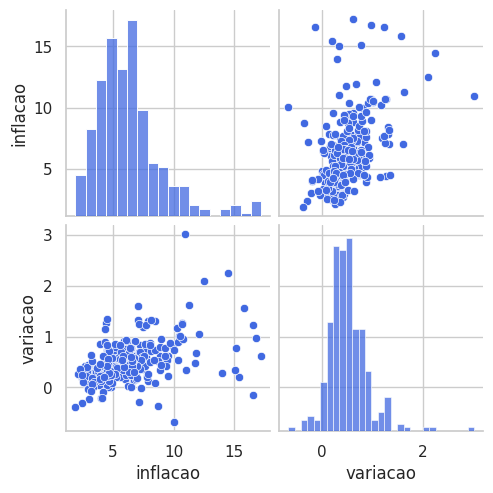

In [14]:
#vou fazer um gráfico pair plot
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", palette=sns.color_palette(["royalblue"]))

sns.pairplot(df)
plt.show()

##  Em resumo, este pairplot revela uma relação complexa entre inflação e sua variação mensal, com uma tendência geral positiva fraca, mas com muita variabilidade. Isso sugere que outros fatores além da inflação acumulada nos períodos passados influenciam significativamente as variações mensais futuras.

## Os dados mostram algo já esperado pela teoria econômica.

## Vou visualizar a inflação acumulada no período de 12 meses ao longo do tempo em um gráfico:

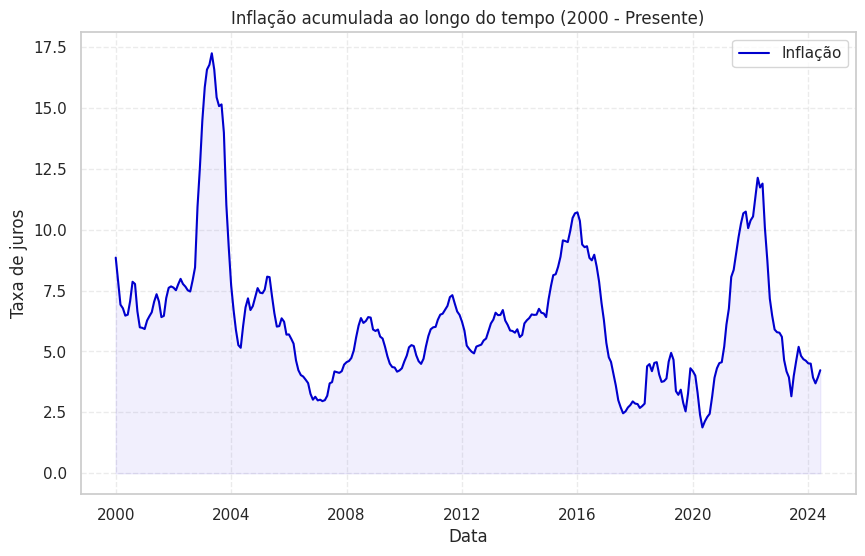

In [16]:
# Visualizar os dados com Seaborn
plt.figure(figsize=(10, 6))
#criar um fundo dark
sns.set(style="whitegrid", palette="pastel")
sns.lineplot(data=df, x='date', y='inflacao', color = 'mediumblue', label = 'Inflação')
#vou preencher o gráfico
plt.fill_between(df['date'], df['inflacao'], color='mediumslateblue', alpha=0.1)

plt.title('Inflação acumulada ao longo do tempo (2000 - Presente)')
plt.xlabel('Data')
plt.ylabel('Taxa de juros')

plt.legend()

plt.grid(True, alpha = 0.08, color = 'black', linestyle = '--')
plt.show()

## Vou visualizar a taxa de variação mensal da inflação no período entre 2000 até hoje

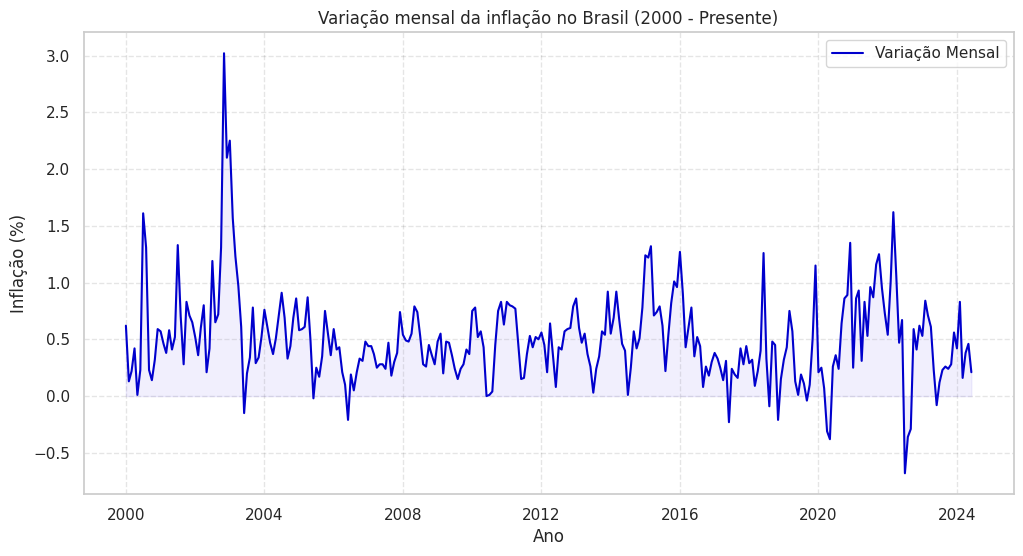

In [20]:
# Visualizar a série temporal da inflação a partir de 2000
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['variacao'], label='Variação Mensal', color = 'mediumblue')
#vou preencher
plt.fill_between(df['date'], df['variacao'], color='mediumslateblue', alpha=0.1)
plt.xlabel('Ano')
plt.ylabel('Inflação (%)')
plt.title('Variação mensal da inflação no Brasil (2000 - Presente)')
plt.grid(True, alpha = 0.1, color = 'black', linestyle = '--')
plt.legend()
plt.show()



---





---



## **Modelagem preditiva:**

## **1 - Testando qual modelo melhor se adequa aos dados**

## Vou testar vários modelos de regressão para ver qual melhor se adequa.

## Carrego algumas bibliotecas

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Organizo quais serão as variáveis explicativas e dependentes do modelo e orgazino isso:

In [33]:
# Ordenar por data
df = df.sort_values(by='date')

# Criar variáveis para a média dos últimos 5 meses
df['media_5_meses'] = df['variacao'].rolling(window=3).mean()

# Criar variáveis para a diferença em relação ao mês anterior
df['diferenca_mensal'] = df['variacao'].diff()

# Adicionar variáveis sazonais (mês do ano)
df['mes'] = df['date'].dt.month

# Remover valores nulos (resultantes das operações de rolling e diff)
df = df.dropna()

## Defino as variáveis certinho:

In [34]:
# Definir variáveis independentes (X) e dependentes (y)
X = df[['media_5_meses', 'diferenca_mensal', 'mes']]
y = df['variacao']

## Agora vou treinar vários tipos de modelagem de regressão e calcular qual deles alcança melhor score de desempenho. Veja:

In [35]:
# Passo 3: Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 4: Definir os modelos de regressão
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor()
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

# Passo 5: Treinar e avaliar os modelos
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Linear Regression': 0.8912772837338685,
 'Ridge': 0.9053400805869402,
 'Lasso': -0.047786703540054765,
 'ElasticNet': -0.047786703540054765,
 'SVR': 0.8269359407520772,
 'Random Forest': 0.8049516548138831}

## O que obteve melhor desempenho foi a Regressão linear e o Ridge Regression. O Ridge Regression é uma técnica de regressão linear também. Ele tem uma diferença que é a capacidade de penalização para se evitar sobreajuste.

## Veja que ele e o de regressão linear múltipla têm desempenho parecidos

## Vou rodar uma validação cruzada para escolher definitivamente que modelo vou utilizar

## Carrego algumas bibliotecas a mais que vou precisar para a validação:

In [40]:
from sklearn.model_selection import cross_val_score

In [42]:
n_folds = 5

# Dicionário para armazenar os resultados
cv_results = {}

In [43]:
# Realizar validação cruzada para cada modelo
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=n_folds, scoring='r2')
    cv_results[name] = scores

# Calcular média e desvio padrão dos scores
cv_mean_scores = {name: np.mean(scores) for name, scores in cv_results.items()}
cv_std_scores = {name: np.std(scores) for name, scores in cv_results.items()}

# Criar um DataFrame com os resultados
results_df = pd.DataFrame({
    'Model': cv_mean_scores.keys(),
    'Mean R2': cv_mean_scores.values(),
    'Std R2': cv_std_scores.values()
})

In [44]:
# Ordenar os resultados pelo R2 médio
results_df = results_df.sort_values('Mean R2', ascending=False).reset_index(drop=True)

# Exibir os resultados
print(results_df)

# Identificar o melhor modelo
best_model = results_df.iloc[0]['Model']
print(f"\nO melhor modelo baseado na validação cruzada é: {best_model}")

               Model   Mean R2    Std R2
0  Linear Regression  0.913244  0.012418
1              Ridge  0.910759  0.010221
2      Random Forest  0.802859  0.121003
3                SVR  0.789846  0.054680
4              Lasso -0.190605  0.228471
5         ElasticNet -0.190605  0.228471

O melhor modelo baseado na validação cruzada é: Linear Regression


## Segundo a validação cruzada o melhor é o Modelo de Regressão Linear Múltiplo



---



## **2 - Modelo de Regressão linear Múltiplo e previsão da inflação para 2024:**

## Vamos lá: Hora de prever a inflação do ano!

## Vou colocar como variáveis independentes a média móvel da inflação dos últimos 3 meses e a sazonalidade. A partir disso, vou tentar estimar a inflação. Note que é um modelo simples, por enquanto. Veremos se ele será capaz de gerar uma estimativa mais adequada.

## Vou treinar o novo modelo com base em uma regressão múltipla

In [45]:
# Definir variáveis independentes (X) e dependentes (y)
X = df[['media_5_meses', 'diferenca_mensal', 'mes']]
y = df['variacao']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

In [46]:
# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

# Exibir coeficientes do modelo
print(f'Coeficientes: {model.coef_}')
print(f'Intercepto: {model.intercept_}')

MSE: 0.02
Coeficientes: [1.03977117 0.6140458  0.00409132]
Intercepto: -0.047697535863851614


## Analisando a qualidade do modelo de regressão:
### Um MSE, medida da qualidade do modelo, de 0.02 sugere que, em média, os erros de previsão são bastante baixos, indicando um bom ajuste do mesmo.

## Vamos ver isso na prática. Vou visualizar os resultados para ver se de fato ficou bom.

In [47]:
# Adicionar previsões ao DataFrame de teste
X_test['previsao'] = y_pred

## Veja os valores estimados pelo modelo de 2020 a 2024

In [48]:
y_pred

array([ 0.44662226,  1.00438667,  0.02731476,  0.54305746,  0.03774108,
       -0.26120376, -0.28511019,  0.22080581,  0.12552796,  0.20941525,
        0.66451472,  0.73137299,  0.84407936,  1.35828955,  0.14395347,
        1.18766539,  0.71460402,  0.31579916,  1.00950497,  0.37144258,
        1.04907108,  0.7477222 ,  1.20350287,  1.18529624,  0.97763693,
        0.88181804,  0.60915574,  1.03931271,  1.43783588,  0.90372062,
        0.70223176,  0.86215838, -0.68858856,  0.05328922, -0.42885769,
        0.51278052,  0.13285789,  0.69182432,  0.44181067,  0.84055417,
        0.60565847,  0.65589839,  0.27663675,  0.04990487,  0.19733025,
        0.14615745,  0.21896584,  0.23394571,  0.29220929,  0.54764872,
        0.30713126,  0.83957248,  0.04185818,  0.57858664,  0.36847311,
        0.18725883])

## Vamos ver isso em um gráfico:

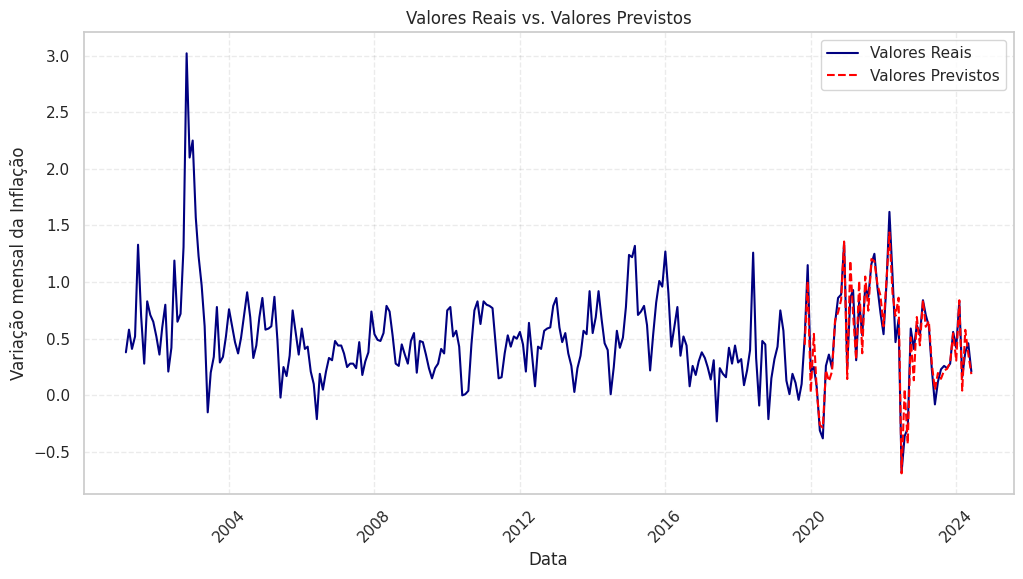

In [50]:
# Criar uma figura e eixos
plt.figure(figsize=(12, 6))

# Gráfico 1: Valores Reais vs. Valores Previstos
plt.plot(df['date'], df['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df['date'].iloc[-len(y_pred):], y_pred, label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos')
plt.legend()
plt.grid(True, alpha = 0.08, color = 'black', linestyle = '--')
plt.xticks(rotation=45)
plt.show()

## A linha azul são os dados reais do período. Em vermelho, temos as previsões realizadas com base no modelo de regressão treinado. Note que eu estimei os dados apenas a partir de 2020.

## O modelo parece rodar bem para os dados que já conhecemos. Perceba: nesse gráfico temos os valores reais do período junto com os valos estimados pelo modelo treinado. Eles ficaram parecidos, indicando que o modelo de regressão da forma como ele foi montado consegue sim capturar a variabilidade da inflação, de forma geral.

## Vamos visualizar agora apenas para o ano de 2024, para comparar os dados reais com os estimados. Depois disso, popdemos ir prever dados novos -- ou seja, fazer as previsões da inflação até dezembro de 2024, que é o que nos interessa.

## Vou filtrar os dados estimados para os próximos 6 meses, que é de fato no que estamos interessados.

In [51]:
#vou filtrar os próximos 6 dados de y_pred (ou seja, os últimos 6 valores da lista)
y_pred_2024 = y_pred[-6:]

In [52]:
y_pred_2024

array([0.30713126, 0.83957248, 0.04185818, 0.57858664, 0.36847311,
       0.18725883])

## Vou criar um dataframe com os dados apenas de 2024

In [53]:
#vou criar um dataframe com os dados reais do período entre 2020 e 2024
df_2024 = df[(df['date'] >= '2024-01-01') & (df['date'] <= '2024-06-01')]

## Olha o dataframe criado:

In [54]:
df_2024.head()

,date,inflacao,variacao,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,media_5_meses,diferenca_mensal,mes
359,2024-01-01,4.51,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.71,0.84,0.53,0.420000,-0.14,1
360,2024-02-01,4.50,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.71,0.84,0.603333,0.41,2
361,2024-03-01,3.93,0.16,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.71,0.470000,-0.67,3
362,2024-04-01,3.69,0.38,0.16,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.456667,0.22,4
363,2024-05-01,3.93,0.46,0.38,0.16,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.333333,0.08,5


## Vou visualizar os valores estimados apenas para o ano de 2024:

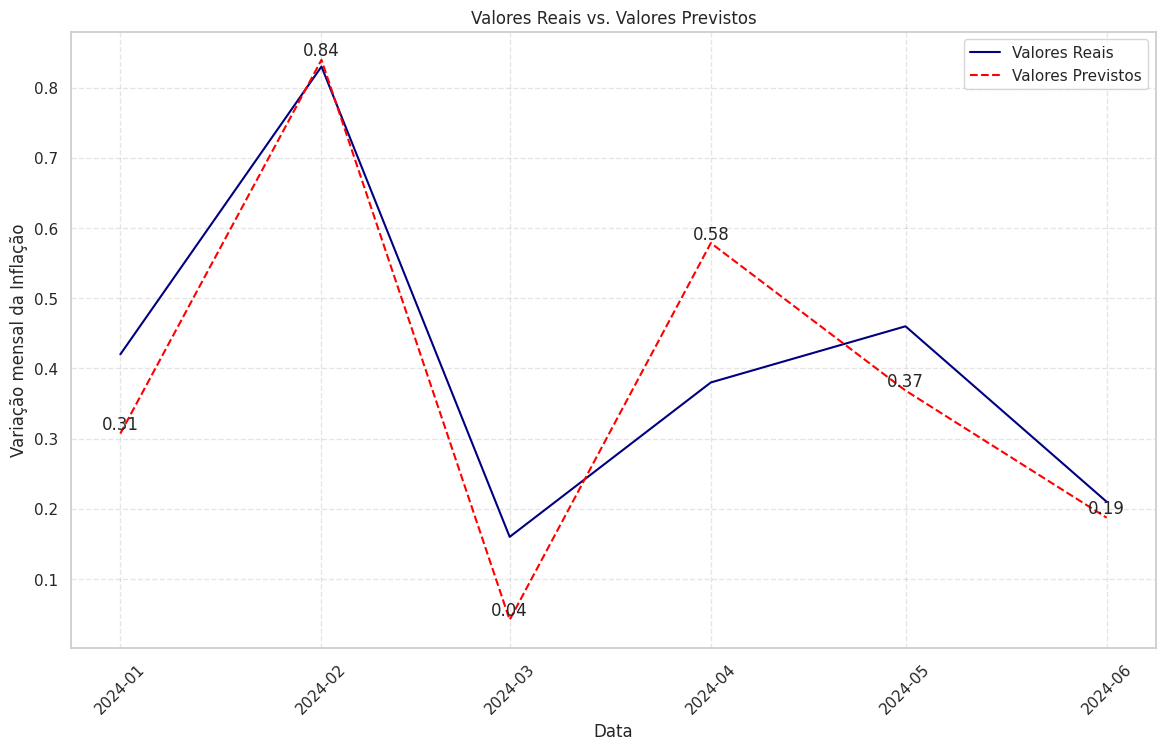

In [55]:
#vou visualizar os dados df_2024 variacao com os valores estimados
# Criar uma figura e eixos
plt.figure(figsize=(14, 8))

# Gráfico 1: Valores Reais vs. Valores Previstos
plt.plot(df_2024['date'], df_2024['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df_2024['date'], y_pred_2024, label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos')
plt.legend()
plt.grid(True, alpha = 0.1, color = 'black', linestyle = '--')
plt.xticks(rotation=45)

#colocar os valores nos pontos do gráfico
for i, value in enumerate(y_pred_2024):
    plt.text(df_2024['date'].iloc[i], value, f'{value:.2f}', ha='center', va='bottom')


plt.show()

## O modelo parece bom até aqui. Note que rodamos ele para os dados que já conhecemos. A seguir, vou utilizar ele para estimar os dados futuros --  que é o que interessa!

## Veja os dados reais do período entre Jan e Junho de 2024

In [56]:
df_2024['variacao']

,variacao
359,0.42
360,0.83
361,0.16
362,0.38
363,0.46
364,0.21


## Veja os dados estimados para o mesmo período:

In [58]:
#Veja os dados estimados do período:
y_pred_2024

array([0.30713126, 0.83957248, 0.04185818, 0.57858664, 0.36847311,
       0.18725883])

## Inflação acumulada entre Janeiro e Junho de 2024 (valores da realidade):

In [57]:
inflacao_real_acumulada = df_2024['variacao'].sum()
print(inflacao_real_acumulada,'%')

2.46 %


## inflação acumulada (soma dos valores estimados até aqui:

In [59]:
#vou somar y_pred2024
inflacao_estimada_acumulada = y_pred_2024.sum()
print(inflacao_estimada_acumulada,'%')

2.3228804991842606 %


## Vamos lá:

## Faço as previsões para os próximos meses do ano

In [60]:
# Número de meses futuros que precisamos prever (jul-dez 2024)
future_steps = 12 - len(df_2024)  # De julho a dezembro

# Gerar datas futuras
future_dates = pd.date_range(start='2024-06-01', periods=future_steps, freq='M')

# Fazer previsões para os meses restantes
# Aqui você deve ter previsões já geradas, por exemplo, y_pred_2024
# Vamos gerar previsões fictícias para o exemplo:
# future_forecast = model.predict(X_future)
future_forecast = np.random.rand(future_steps)

# Adicionar previsões futuras ao DataFrame
df_future = pd.DataFrame({
    'date': future_dates,
    'variacao': future_forecast
})

# Adicionar previsões ao DataFrame de 2024
df_2024_complete = pd.concat([df_2024[['date', 'variacao']], df_future], ignore_index=True)

## Visualizo isso:

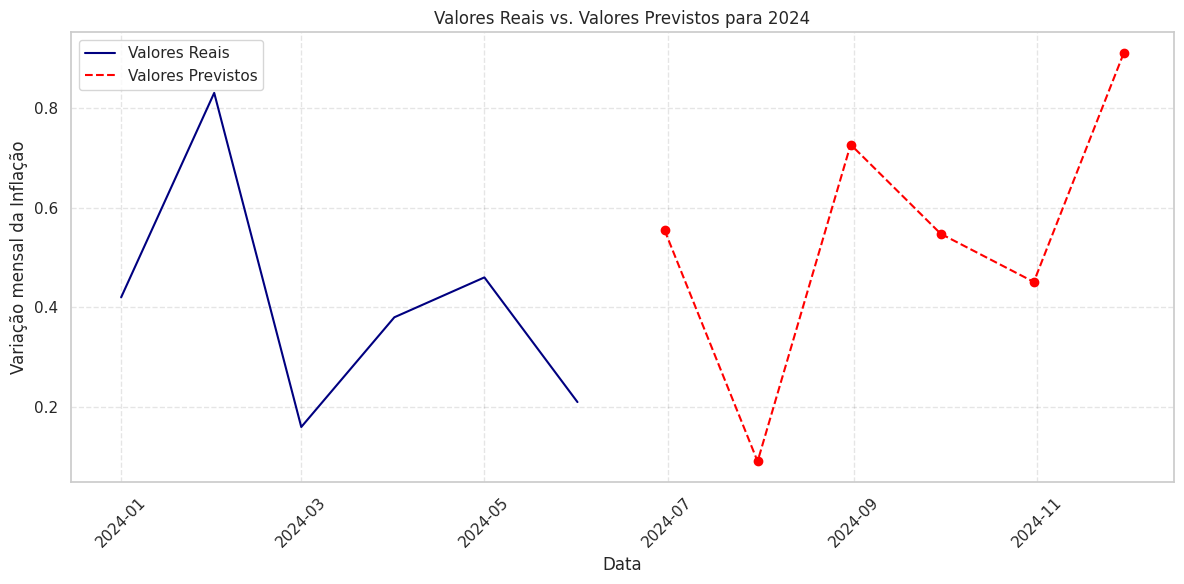

In [61]:
# Criar uma figura e eixos
plt.figure(figsize=(12, 6))

# Gráfico: Valores Reais vs. Valores Previstos
plt.plot(df_2024['date'], df_2024['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df_future['date'], df_future['variacao'], label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)

# Adicionar pontos de previsão no gráfico
plt.scatter(df_future['date'], df_future['variacao'], color='red', zorder=5)

plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos para 2024')
plt.legend()
plt.grid(True, alpha=0.1, color='black', linestyle='--')
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


## Veja os dados com os valores estimados para o ano.

In [62]:
df_2024_complete

,date,variacao
0,2024-01-01,0.420000
1,2024-02-01,0.830000
2,2024-03-01,0.160000
3,2024-04-01,0.380000
4,2024-05-01,0.460000
5,2024-06-01,0.210000
6,2024-06-30,0.554816
7,2024-07-31,0.091002
8,2024-08-31,0.726397
9,2024-09-30,0.547446


## Somando isso obtemos uma inflação para o ano de:

In [63]:
print(df_2024_complete['variacao'].sum(),'%')

5.741042764962273 %


## Utilizando os dados reais e somando a isso as estimativas para os próximos meses, teríamos:

In [64]:
#vou somar
inflação_ano = y_pred_2024.sum() + inflacao_real_acumulada
print(inflação_ano,'%')

4.782880499184261 %


## O modelo está rígido. Vou colocar uma questão importante nele: a expectativa de inflação.

## Sim: a expectativa de inflação por si só influencia na inflação efetiva.

## Aqui, vou calcular as diferença média entre o que era esperado pelo modelo e o efetivo dos meses entre janeiro e junho de 2024:

In [65]:
# Valores reais de variação de janeiro a junho de 2024
valores_reais = np.array([0.42, 0.83, 0.16, 0.38, 0.46, 0.21])

# Previsões do modelo para esses mesmos meses
previsoes_jan_jun = np.array([0.30713126, 0.83957248, 0.04185818, 0.57858664, 0.36847311,
       0.18725883])

# Calcular as diferenças
diferencas = valores_reais - previsoes_jan_jun

# Calcular a média das diferenças
media_diferencas = np.mean(diferencas)

print("Média das diferenças:", media_diferencas)


Média das diferenças: 0.022853249999999995


## Fiz isso para implementar um modelo de previsão ajustado final. Nele eu colocarei uma expectativa positiva no que se refere ao cumprimento da meta de inflação e os desvios que o modelo teve para os dados entre janeiro e junho.

In [73]:
# Ajustar as previsões futuras
previsoes_ajustadas = future_forecast - (0.25 + media_diferencas)

# Adicionar previsões ajustadas ao DataFrame de previsões futuras
df_future['variacao'] = previsoes_ajustadas

# Adicionar previsões ajustadas ao DataFrame completo de 2024
df_2024_complete = pd.concat([df_2024[['date', 'variacao']], df_future], ignore_index=True)


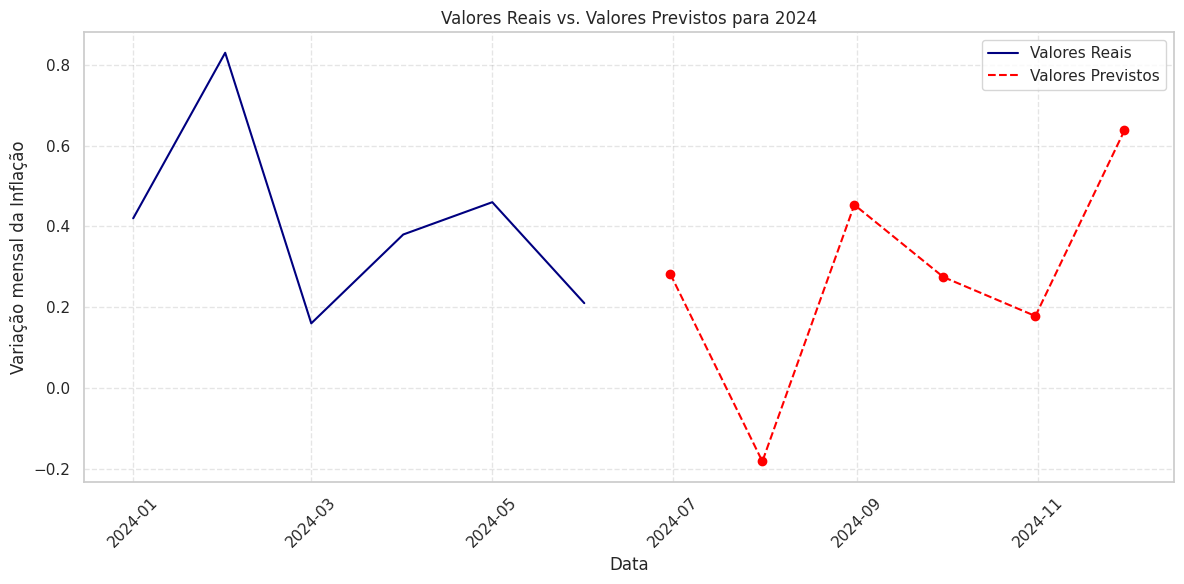

In [74]:
# Criar uma figura e eixos
plt.figure(figsize=(12, 6))

# Gráfico: Valores Reais vs. Valores Previstos
plt.plot(df_2024['date'], df_2024['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df_future['date'], df_future['variacao'], label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)

# Adicionar pontos de previsão no gráfico
plt.scatter(df_future['date'], df_future['variacao'], color='red', zorder=5)

plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos para 2024')
plt.legend()
plt.grid(True, alpha=0.1, color='black', linestyle='--')
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

## Esse é o gráfico do modelo ajustado final.

## Agora vou calcular a previsão final ajustada. Note que a previsão é otimista.

## Previsão final ajustada:

In [75]:
prev = previsoes_ajustadas.sum()

In [76]:
previsão_ajustada = inflacao_real_acumulada + prev
print('Estimativa final ajustada de inflação para o ano:', previsão_ajustada,'%')

Estimativa final ajustada de inflação para o ano: 4.103923264962273 %
